# Using Pytorch to Predict Energy Consumption

First loading the necessary packages:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, custom_format, currency_format

from IPython.display import clear_output

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
pd.set_option('display.max.columns', 500)

Then reading in the data:

In [3]:
data = (pd.read_csv("data_prepped.csv",
                    parse_dates=['date'])
        .assign(year = lambda x: x.date.dt.year))

In [4]:
dt_train = data.query("year <= 2017")
dt_test = data.query("year == 2018")
holdout = data.query("year == 2019")

In [5]:
dt_train.head()

,date,ALT_meantemp,ALT_precipitation,ALT_cloudcoverage,ALT_humidity,BAS_meantemp,BAS_precipitation,BAS_cloudcoverage,BAS_humidity,BER_meantemp,BER_precipitation,BER_cloudcoverage,BER_humidity,DAV_meantemp,DAV_precipitation,DAV_humidity,GVE_meantemp,GVE_precipitation,GVE_cloudcoverage,GVE_humidity,LUG_meantemp,LUG_precipitation,LUG_cloudcoverage,LUG_humidity,LUZ_meantemp,LUZ_precipitation,LUZ_humidity,NEU_meantemp,NEU_precipitation,NEU_humidity,SMA_meantemp,SMA_precipitation,SMA_cloudcoverage,SMA_humidity,STG_meantemp,STG_precipitation,STG_cloudcoverage,STG_humidity,mwh,date_year,date_CHAscension,date_CHBerchtoldsDay,date_CHConfederationDay,date_CHKnabenschiessen,date_CHSechselaeuten,month,week_day,week_in_year,quarter,date_christmas,date_dow_Sun,date_dow_Mon,date_dow_Tue,date_dow_Wed,date_dow_Thu,date_dow_Fri,date_dow_Sat,date_month_Jan,date_month_Feb,date_month_Mar,date_month_Apr,date_month_May,date_month_Jun,date_month_Jul,date_month_Aug,date_month_Sep,date_month_Oct,date_month_Nov,date_month_Dec,day_of_year_X1,day_of_year_X2,day_of_year_X3,day_of_year_X4,day_of_year_X5,day_of_year_X6,day_of_year_X7,day_of_year_X8,day_of_year_X9,day_of_year_X10,day_of_year_X11,day_of_year_X12,day_of_year_X13,day_of_year_X14,day_of_year_X15,day_of_year_X16,day_of_year_X17,day_of_year_X18,day_of_year_X19,day_of_year_X20,day_of_year_X21,day_of_year_X22,day_of_year_X23,day_of_year_X24,day_of_year_X25,day_of_year_X26,day_of_year_X27,day_of_year_X28,day_of_year_X29,day_of_year_X30,day_of_year_X31,day_of_year_X32,day_of_year_X33,day_of_year_X34,day_of_year_X35,day_of_year_X36,day_of_year_X37,day_of_year_X38,day_of_year_X39,day_of_year_X40,day_of_year_X41,day_of_year_X42,day_of_year_X43,day_of_year_X44,day_of_year_X45,day_of_year_X46,day_of_year_X47,day_of_year_X48,day_of_year_X49,day_of_year_X50,day_of_year_X51,day_of_year_X52,day_of_year_X53,day_of_year_X54,day_of_year_X55,day_of_year_X56,day_of_year_X57,day_of_year_X58,day_of_year_X59,day_of_year_X60,day_of_year_X61,day_of_year_X62,day_of_year_X63,day_of_year_X64,day_of_year_X65,day_of_year_X66,day_of_year_X67,day_of_year_X68,day_of_year_X69,day_of_year_X70,day_of_year_X71,day_of_year_X72,day_of_year_X73,day_of_year_X74,day_of_year_X75,day_of_year_X76,day_of_year_X77,day_of_year_X78,day_of_year_X79,day_of_year_X80,day_of_year_X81,day_of_year_X82,day_of_year_X83,day_of_year_X84,day_of_year_X85,day_of_year_X86,day_of_year_X87,day_of_year_X88,day_of_year_X89,day_of_year_X90,day_of_year_X91,day_of_year_X92,day_of_year_X93,day_of_year_X94,day_of_year_X95,day_of_year_X96,day_of_year_X97,day_of_year_X98,day_of_year_X99,day_of_year_X100,day_of_year_X101,day_of_year_X102,day_of_year_X103,day_of_year_X104,day_of_year_X105,day_of_year_X106,day_of_year_X107,day_of_year_X108,day_of_year_X109,day_of_year_X110,day_of_year_X111,day_of_year_X112,day_of_year_X113,day_of_year_X114,day_of_year_X115,day_of_year_X116,day_of_year_X117,day_of_year_X118,day_of_year_X119,day_of_year_X120,day_of_year_X121,day_of_year_X122,day_of_year_X123,day_of_year_X124,day_of_year_X125,day_of_year_X126,day_of_year_X127,day_of_year_X128,day_of_year_X129,day_of_year_X130,day_of_year_X131,day_of_year_X132,day_of_year_X133,day_of_year_X134,day_of_year_X135,day_of_year_X136,day_of_year_X137,day_of_year_X138,day_of_year_X139,day_of_year_X140,day_of_year_X141,day_of_year_X142,day_of_year_X143,day_of_year_X144,day_of_year_X145,day_of_year_X146,day_of_year_X147,day_of_year_X148,day_of_year_X149,day_of_year_X150,day_of_year_X151,day_of_year_X152,day_of_year_X153,day_of_year_X154,day_of_year_X155,day_of_year_X156,day_of_year_X157,day_of_year_X158,day_of_year_X159,day_of_year_X160,day_of_year_X161,day_of_year_X162,day_of_year_X163,day_of_year_X164,day_of_year_X165,day_of_year_X166,day_of_year_X167,day_of_year_X168,day_of_year_X169,day_of_year_X170,day_of_year_X171,day_of_year_X172,day_of_year_X173,day_of_year_X174,day_of_year_X175,day_of_year_X176,day_of_year_X177,day_of_year_X178,day_of_year_X179,day_of_year_X180,day_of_year_X181,day_of_year_X182,

I need to drop the date column as well in the X variable matrix, as it can't be used as a predictor:

In [6]:
X_train = dt_train.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_train = dt_train["mwh"].reset_index(drop=True)

X_test = dt_test.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_test = dt_test["mwh"].reset_index(drop=True)

In [7]:
class CustomDataset(torch.utils.data.Dataset):
  '''
  Prepare the custom dataset for regression
  '''

  def __init__(self, X, y):
    # Normally, here would be the sklearn part, which I've done above

    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.from_numpy(np.float32(np.asarray(X)))
      self.y = torch.from_numpy(np.float32(np.asarray(y)))

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [8]:
train_dataset = CustomDataset(X=X_train, y=y_train)
test_dataset = CustomDataset(X=X_test, y=y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
X_train.shape[1]

436

In [10]:
class ANN(nn.Module):
    '''
    Artificial Neural Network
    '''
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(len(X_train.columns), 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        '''
        Forward pass
        '''
        return self.layers(x)

model = ANN()
model

ANN(
  (layers): Sequential(
    (0): Linear(in_features=436, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [11]:
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer, loss_list):
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Store batch's loss at end of epoch I guess?
    print(f"Training loss: {loss.item():>7f}")
    loss_list.append(loss.item())

def test_loop(dataloader, model, loss_fn, loss_list):
    num_batches = len(dataloader)
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Testing loss: {test_loss:>8f} \n")

    # Store batch's loss at end of epoch I guess?
    loss_list.append(test_loss)

In [13]:
# Actually running the loops
training_losses = []
testing_losses = []

for t in range(90):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_function, optimizer, training_losses)
    # clear output such that the last testing loss remains visible
    clear_output(wait=True)
    test_loop(test_loader, model, loss_function, testing_losses)

Testing loss: 4201.927714 



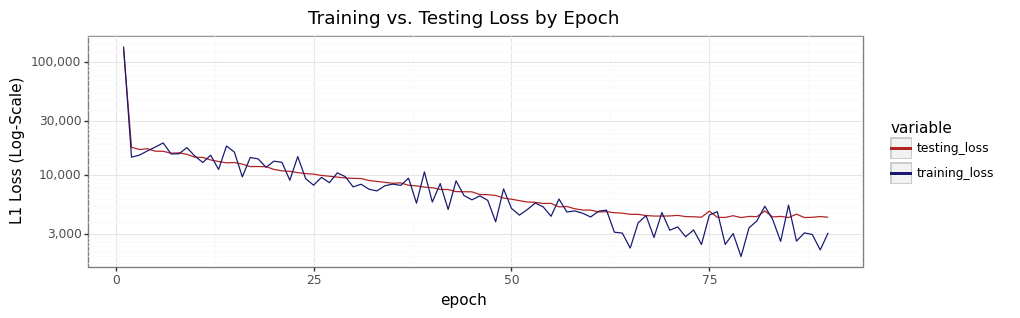

<ggplot: (137777832396)>

In [24]:
def evaluation_plot(training_list, testing_list):
    out_plot = (
        ggplot(data=(pd.DataFrame({"training_loss": training_list,
                                    "testing_loss": testing_list})
                    .assign(epoch=lambda x: range(1, x.shape[0] + 1))
                    .melt(id_vars='epoch')
                    ),
            mapping=aes(x='epoch', y='value', colour='variable')) +
        labs(title='Training vs. Testing Loss by Epoch',
             y = 'L1 Loss (Log-Scale)') +
        geom_line() +
        scale_y_log10(labels=comma_format()) +
        scale_colour_manual(values=['firebrick', 'midnightblue']) +
        theme_bw() +
        theme(figure_size=[10,3])
    )

    return out_plot

p = evaluation_plot(training_losses, testing_losses)
p

In [25]:
p.save(dpi=350, filename='python1.png')

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 10 x 3 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python1.png


### Evaluating performance on the validation set

Then, making predictions on the entire test set to compute the validation $R^2$:

In [16]:
# Set to evaluation mode
model.eval()

# Create empty list to store predictions
y_pred = []

# Iterate through new data in batches and get predictions
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X).squeeze()
        y_pred.append(pred)

# Combine predictions into one tensor
y_pred = torch.concat(y_pred).numpy()

# Evaluate using R-Squared
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R squared score: {r2:.4f}")

R squared score: 0.9385


### Evaluating performance on the holdout dataset:

In [17]:
holdout_array = holdout.drop(['date', 'mwh'], axis=1).values
holdout_tensor = torch.Tensor(holdout_array)

In [18]:
y_pred_holdout = model(holdout_tensor).squeeze().tolist()
y_pred_holdout[1:10]

[161014.0,
 180290.171875,
 184052.265625,
 161502.84375,
 150189.984375,
 183609.625,
 188218.21875,
 191423.8125,
 193047.71875]

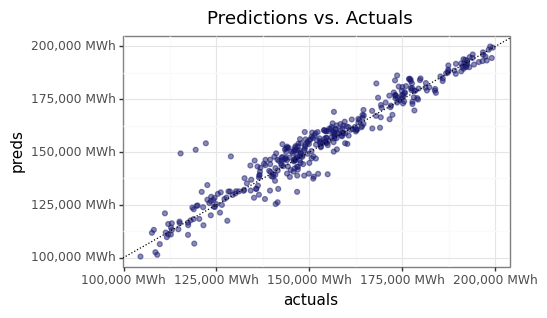

<ggplot: (137771148529)>

In [19]:
(
    ggplot(data=(pd.DataFrame({'actuals': holdout.mwh,
                               'preds': y_pred_holdout})
                 ),
           mapping=aes(x='actuals', y='preds')) +
    geom_point(alpha=0.5, colour='midnightblue') +
    geom_abline(linetype='dotted') +
    labs(title='Predictions vs. Actuals') +
    scale_y_continuous(labels=currency_format(prefix='', suffix=' MWh', big_mark=',', digits=0)) +
    scale_x_continuous(labels=currency_format(prefix='', suffix=' MWh', big_mark=',', digits=0)) +
    theme_bw() +
    theme(figure_size=[5,3])
)


In [20]:
r2 = r2_score(holdout['mwh'], y_pred_holdout)
print(f"R squared score on the holdout dataset: {r2:.4f}")

R squared score on the holdout dataset: 0.9315


Let's visualise how the model predicted on the holdout set:

In [21]:
(pd.DataFrame({'Predictions': y_pred_holdout,
                               'Actuals': holdout['mwh'],
                               'Date': holdout['date']})
 .melt(id_vars='Date')
 )

,Date,variable,value
0,2019-01-01,Predictions,147326.171875
1,2019-01-02,Predictions,161014.000000
2,2019-01-03,Predictions,180290.171875
3,2019-01-04,Predictions,184052.265625
4,2019-01-05,Predictions,161502.843750
...,...,...,...
725,2019-12-27,Actuals,152216.038314
726,2019-12-28,Actuals,148591.748349
727,2019-12-29,Actuals,146691.025942
728,2019-12-30,Actuals,160499.418914


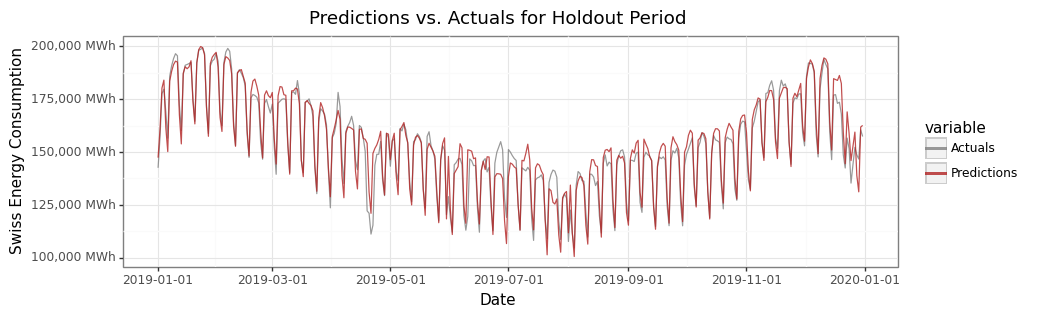

<ggplot: (137771148388)>

In [22]:
p = (
    ggplot(data=(pd.DataFrame({'Predictions': y_pred_holdout,
                               'Actuals': holdout['mwh'],
                               'Date': holdout['date']})
                 .melt(id_vars='Date')
                 ),
           mapping=aes(x='Date', y='value', colour='variable')) +
    geom_line(alpha=0.8) +
    labs(title='Predictions vs. Actuals for Holdout Period',
         y='Swiss Energy Consumption') +
    scale_y_continuous(labels = currency_format(prefix='', 
                                                suffix=' MWh',
                                                big_mark=',', 
                                                digits=0)) +
    scale_colour_manual(values=['grey', 'firebrick']) +
    theme_bw() +
    theme(figure_size=[10,3])
)

p

In [23]:
p.save(dpi=350, filename="python2.png")

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 10 x 3 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python2.png
